In [ ]:
!pip install -qU "langchain[groq]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain.chat_models import init_chat_model

model = init_chat_model("llama-3.3-70b-versatile", model_provider="groq")

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate

# message = [
#     SystemMessage(content="you are proffesional food cook"),
#     HumanMessage(content="idly"),
# ]

# # we can also use model.invoke()

# reply = model.invoke(message)

# print(reply.content)

We can find streaming type in documentation and it is nothing but getting output from llm token by token

Lets start with prompt templates


Here we use system message for entire step in real time we take input separately as system message and user input

In [ ]:
system_template = "Give 'yes' if {inp} is a food item otherwise 'No'. and give only one word answer either 'yes' or 'no'"

prompt_template = ChatPromptTemplate.from_messages(
    [("system",system_template),("user","input")]
)

prompt = prompt_template.invoke({"inp":"mobile"})



response = model.invoke(prompt)
print(response.content)






No


Lang chain completed (nearly) and we further go with lang graph for easy way doing big things

In [ ]:
!pip install -U langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 945.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 6.4 MB/s eta 0:00:00


In [ ]:
pip install -U langchain-tavily

In [ ]:
import os

os.environ["TAVILY_API_KEY"] = "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"

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END

from langchain_tavily import TavilySearch

from langgraph.prebuilt import ToolNode, tools_condition

from langchain_core.messages import BaseMessage


# Adding memory to the llm

from langgraph.checkpoint.memory import InMemorySaver

memory = InMemorySaver()

tool = TavilySearch(max_results=2)

tools = [tool]

# tool = TavilySearch(max_results=2)
# tools = [tool]
# model_with_tools = model.bind_tools(tools)


class State(TypedDict):

  messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)




In [ ]:
model_with_tools = model.bind_tools(tools)



config = {"configurable": {"thread_id": "1"}}


def chatbot(state: State):
    return {"messages": [model_with_tools.invoke(state["messages"],config)]}

graph_builder.add_node("chatbot", chatbot)


tool_node = ToolNode(tools=[tool])

graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot",tools_condition)


graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START, "chatbot")

# graph_builder.add_edge("chatbot",END)

graph = graph_builder.compile(checkpointer=memory)

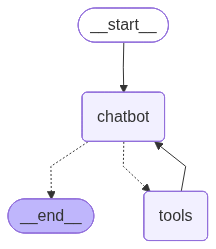

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:



def stream_graph_updates(user_input: str):
    # for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
    #     for value in event.values():
    #         print("Assistant:", event.values["messages"][-1].content)

    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]},config)
    print("Assistant:", result["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hello
Assistant: I can help with general information and tasks. What do you need help with?
User: my name is vars
Assistant: Hello Vars, it's nice to meet you. Is there something I can help you with or would you like to chat?
User: can you tell me my name
Assistant: Your name is Vars.
User: q
Goodbye!


From Human intervention is pending

And for multimodel data sharing refer langchain multimodel docs or gemini multimodal docs both are very easy to use or understand